```In this exercise you will experience with an important and often neglected issue in the data scientist work - the train-test split. For a specific dataset we will examine different ways to split it and will understand the limitations and constraints we have to take when creating a good train-test split.```

```~ Ittai Haran```

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def maps(func, lister): # if you hate python 3 as much as I do you might want to use this
    return list(map(func, lister))

```First, load the dataset. Notice that the dataset is made out of pairs of objects, where each row has the id of each object and the features related to it. How many different objects are there?
We would like to describe the objects and the data using a specific data structure. What structure can best describe the objects and the relations between them (what two objects happen to be in the same sample)?```

In [ ]:
df_edges = pd.read_csv('data.csv')
number_of_objects = len(set(df_edges['index_left'])+set(df_edges['index_right']))

```Use networkx to create a graph describing the objects and the relations between them. How many connected components the graph has? Draw a histogram of their sizes. Are there any edges between left objects and right objects? That kind of graph is called a bipartite graph. For any graph computations, networkx is your friend, and it should be very easy.```

In [ ]:
graph = nx.Graph(list(zip(df_edges['index_left'], df_edges['index_right'])))
print('number of connected compnents: ' + str(len(list(nx.connected_components(graph)))))
plt.hist(maps(len, list(nx.connected_components(graph))), bins=50)
plt.title('sizes of connected components')
plt.xlabel('size')
plt.ylabel('count')
plt.show()

print('number of objects seen both as left and right objects: ' + 
      str(len(set(df_edges['index_left']).intersection(df_edges['index_right'])))

```In order to get a baseline model we will try to have predictions using only one object from each sample. Create a dataset containing only the left objects. Drop duplicates, so every object will appear only once.```

In [18]:
only_lefts = df_edges.drop_duplicates(subset=['index_left'])\
.drop(['index_right']+list(map(lambda x: 'feature_'+str(x)+'_right', range(1, 101))), axis=1)
features_left = list(map(lambda x: 'feature_'+str(x)+'_left', range(1, 101)))

```Split your data randomly with ratio 0.7-0.3. Train a simple model (a random forest, maybe?) to predict the target. Make sure your model isn't overfitted, and try to get the best score you can (on the test segment). Compare your results to a simple baseline - the mean of the target computed on the train segment.```

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(only_lefts[features_left], only_lefts['target'],
                                                    train_size = 0.7, test_size=0.3)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=10, n_jobs=-1)
model.fit(X_train, Y_train)
print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, model.predict(X_test))))

baseline mse on train: 10.885716744895277
baseline mse on test: 10.539744043678267
mse on train: 2.3947950392663064
mse on test: 3.3657243148242006


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


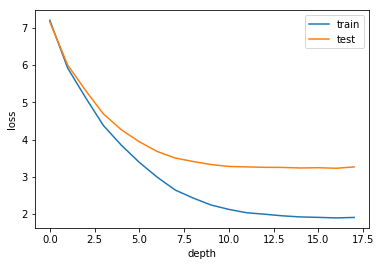

In [20]:
loss_train = []
loss_test = []
for i in range(2,20):
    print(i)
    model = RandomForestRegressor(n_estimators=100, max_depth=i, min_samples_leaf=10, n_jobs=-1)
    model.fit(X_train, Y_train)
    loss_train.append(mean_squared_error(Y_train, model.predict(X_train)))
    loss_test.append(mean_squared_error(Y_test, model.predict(X_test)))
    
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('depth')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

```Repeat that process, only this use all of the sample, and not just the left object. Accordingly, you don't have to drop any duplicates. Use the naive train-test split. Did you get a good score on both train and test? why (or why not)? Do you think the score you got on the test corresponds to the "real" generalization error? why, or why not?```

In [21]:
features_right = list(map(lambda x: 'feature_'+str(x)+'_right', range(1, 101)))
features_all = features_left + features_right

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_edges[features_all], df_edges['target'],
                                                    train_size = 0.7, test_size=0.3)

model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=10, n_jobs=-1)
model.fit(X_train, Y_train)
print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, model.predict(X_test))))

baseline mse on train: 9.142425406381328
baseline mse on test: 9.01175697788043
mse on train: 1.6453207494929756
mse on test: 1.734125992304412


```We will now create a new train-test split, so that every connected component is contained either in the train segment or in the test segment. To do so, implement the following algorithm:```

```while length(train_segment)<0.7*length(data):
    choose randomly a sample s from the data (that is not in train_segment)
    add the connected component containing s to the train_segment
test_segment = data - train_segment```

In [26]:
edges_to_indexes = dict(zip(list(zip(df_edges['index_left'], df_edges['index_right'])), df_edges.index))
nx.set_edge_attributes(graph, edges_to_indexes, name='edge_index')

In [27]:
all_connected_subgraphs = list(enumerate(nx.connected_component_subgraphs(graph)))

In [28]:
train_index = []
components_seen = []
indexes_to_choose_from = list(df_edges.index)
while len(train_index)<=0.7*len(df_edges):
    place = np.random.choice(indexes_to_choose_from)
    sample = df_edges.iloc[place]
    num, connected_component = list(filter(lambda x: sample['index_left'] in list(x[1].nodes()), all_connected_subgraphs))[0]
    components_seen.append(connected_component)
    
    
    train_index.extend(list(map(lambda x: x['edge_index'], connected_component.edges().values())))
    all_connected_subgraphs = list(filter(lambda x: x[0]!=num, all_connected_subgraphs))
    
    train_index = list(set(train_index))
    
    indexes_to_choose_from = list(set(indexes_to_choose_from)-set(train_index))
    
    print(len(train_index))
    

31980
44146
49717
55778
88402
102616
104753
109000
109602
111159
111247
111954
114493
119012


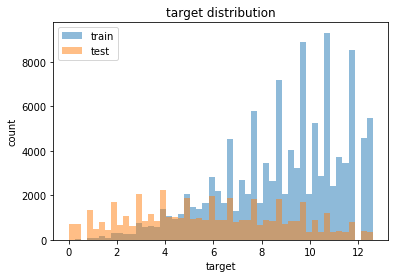

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = (df_edges[features_all].iloc[train_index],
                                    df_edges[features_all].iloc[indexes_to_choose_from],
                                    df_edges['target'].iloc[train_index],
                                    df_edges['target'].iloc[indexes_to_choose_from])

plt.hist(Y_train.values.reshape(-1).astype(float), bins=50, alpha=0.5)
plt.hist(Y_test.values.reshape(-1).astype(float), bins=50, alpha=0.5)
plt.title('target distribution')
plt.xlabel('target')
plt.ylabel('count')
plt.legend(['train', 'test'])
plt.show()

```Train a good model using your train segment. What is the best score you can get on your test? What is the problem with the train-test split method we used? Hint: How many connected components are there in the train segment, and how many are in the test segment? Examine also the distribution of the target, both in the train and in the test. Do they look the same?```

In [33]:
loss_train = []
loss_test = []
for depth in range(2,14):
    model = RandomForestRegressor(n_estimators=100, max_depth=depth, min_samples_leaf=10, n_jobs=-1)
    model.fit(X_train, Y_train)
    loss_train.append(mean_squared_error(Y_train, model.predict(X_train)))
    loss_test.append(mean_squared_error(Y_test, model.predict(X_test)))
    print(loss_train[-1], loss_test[-1])

4.717770954687669 13.67180631056352
4.1938029903810365 12.477989796131823
3.5855692810838002 11.13774233837931
2.932883815101297 9.898608448475128
2.3791037845731595 8.66959056301838
1.8466732850255605 7.682978992851859
1.4653532168879466 7.052798738064851
1.1611604230675379 6.4965170512030594
0.9244634054358645 6.019457935499921
0.7703822540923326 5.7833015275752695
0.6429982853913535 5.531680227938432
0.5494176534898906 5.306649765202517


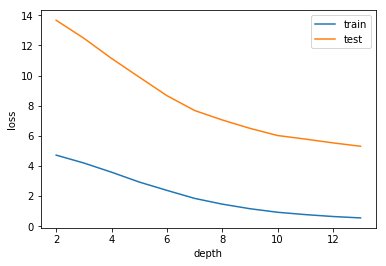

In [34]:
plt.plot(range(2,14), loss_train)
plt.plot(range(2,14), loss_test)
plt.xlabel('depth')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

```Do the train-test split again, only this time make sure you have ~0.7 of the connected components in your train segment. That is, implement the following algorithm:```

```while length(train_segment)<0.7*length(data):
    choose randomly a connected component c from the graph
    add c to the train_segment
test_segment = data-train_segment```

In [35]:
all_connected_subgraphs = shuffle(list(enumerate(nx.connected_component_subgraphs(graph))))
all_connected_subgraphs_lengths = np.cumsum(list(map(lambda x: len(x[1].edges()), all_connected_subgraphs)))
all_connected_subgraphs_lengths = np.array(all_connected_subgraphs_lengths)/float(all_connected_subgraphs_lengths[-1])
place_cut_off = np.argmax(all_connected_subgraphs_lengths>0.7)+1
print(place_cut_off)

103


In [36]:
train_index = [item for sublist in
 maps(lambda x: maps(lambda y: y['edge_index'], x[1].edges().values()), all_connected_subgraphs[:place_cut_off])
 for item in sublist]
indexes_to_choose_from = list(set(list(df_edges.index)) - set(train_index))

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = (df_edges[features_all].iloc[train_index],
                                    df_edges[features_all].iloc[indexes_to_choose_from],
                                    df_edges['target'].iloc[train_index],
                                    df_edges['target'].iloc[indexes_to_choose_from])

```What part of the connected components you have in your train segment this time? Try also look again at the distribution of the target in the two segments.```

C:\Users\MMM\AppData\Local\conda\conda\envs\python3_ittai\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


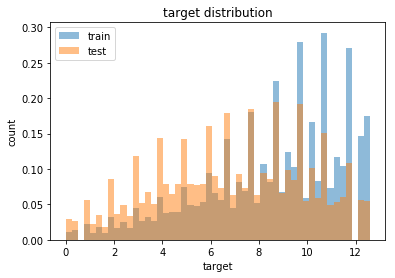

In [39]:
print('part of connected components: ' + str((place_cut_off)/len(all_connected_subgraphs_lengths)))
plt.hist(Y_train.values.reshape(-1).astype(float), bins=50, alpha=0.5, normed=1)
plt.hist(Y_test.values.reshape(-1).astype(float), bins=50, alpha=0.5, normed=1)
plt.title('target distribution')
plt.xlabel('target')
plt.ylabel('count')
plt.legend(['train', 'test'])
plt.show()

```Train a good model using you train segment. What is the best score you can get on your test? Did you get a better score? why?```

In [40]:
loss_train = []
loss_test = []
for depth in range(2,18):
    model = RandomForestRegressor(n_estimators=100, max_depth=depth, min_samples_leaf=10, n_jobs=-1)
    model.fit(X_train, Y_train)
    loss_train.append(mean_squared_error(Y_train, model.predict(X_train)))
    loss_test.append(mean_squared_error(Y_test, model.predict(X_test)))
    print(loss_train[-1], loss_test[-1])
    
# print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
# print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
# print('mse on train: {0}'.format(mean_squared_error(Y_train, model.predict(X_train))))
# print('mse on test: {0}'.format(mean_squared_error(Y_test, model.predict(X_test))))

6.0639327315481335 8.243992569169963
5.405643497162096 7.494453981894873
4.756241414536968 6.468729096360071
4.002063891014853 5.669813557528426
3.2866486310512437 4.957485978223889
2.719287882945254 4.578544644454387
2.2170435181484636 4.081843400471501
1.771168887563158 3.718945586536394
1.4085583291613957 3.348699713020193
1.139498285916937 3.109447794716921
0.9491447101082882 2.9942456547551104
0.7800895786829217 2.8163896203080587
0.6649546848422234 2.737602283549278
0.5722034378578245 2.6848632341680063
0.49488448690505266 2.5866166720618544
0.43084554370025097 2.5449411661103643


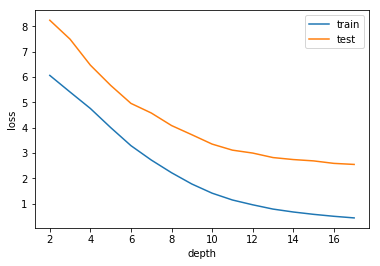

In [45]:
plt.plot(range(2,18), loss_train)
plt.plot(range(2,18), loss_test)
plt.xlabel('depth')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

```Bonus: the data for this exercise was uniquely generated, using MNIST (what? how???). Can you generate a similar dataset? What parameters control this problem? Explain how it can be done.```

## generate data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def maps(func, lister):
    return list(map(func, lister))

In [2]:
count_1 = 12000
count_2 = 6000
connected_count = 200

vertices_1 = list(map(lambda x: str(x)+'_1', list(range(count_1))))
vertices_2 = list(map(lambda x: str(x)+'_2', list(range(count_2))))
all_vertices = vertices_1 + vertices_2

In [3]:
probas_1 = np.linspace(0,1,len(vertices_1))**1.1
probas_1 = probas_1/float(sum(probas_1))

probas_2 = np.linspace(0,1,len(vertices_2))**1.1
probas_2 = probas_2/float(sum(probas_2))

indexes_cut_off_1 = sorted(np.random.choice(list(range(len(vertices_1))), size = connected_count, replace=False, p=probas_1))
indexes_cut_off_2 = sorted(np.random.choice(list(range(len(vertices_2))), size = connected_count, replace=False, p=probas_2))

In [4]:
vertices_1_groups = []
for i,j in zip([0]+indexes_cut_off_1, indexes_cut_off_1):
    vertices_1_groups.append(vertices_1[i:j])
    
vertices_2_groups = []
for i,j in zip([0]+indexes_cut_off_2, indexes_cut_off_2):
    vertices_2_groups.append(vertices_2[i:j])
    
p = 0.3
edges = []
for vert_1, vert_2 in zip(vertices_1_groups, vertices_2_groups):
    edges_count = int(len(vert_1)*len(vert_2)*p)
    edges.extend(list(zip(np.random.choice(vert_1, edges_count), np.random.choice(vert_2, edges_count))))

In [6]:
graph = nx.Graph(edges)
all_vertices = [item for sublist in map(list, sorted(list(nx.connected_components(graph)), key=lambda x: -len(x))) for item in sublist]

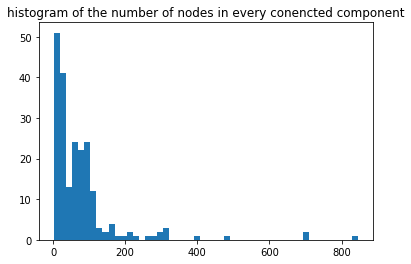

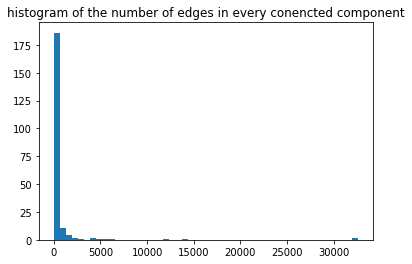

In [7]:
plt.hist(list(map(len, list(nx.connected_components(graph)))), bins=50)
plt.title('histogram of the number of nodes in every conencted component')
plt.show()

plt.hist(list(map(lambda x: len(x.edges()), list(nx.connected_component_subgraphs(graph)))), bins=50)
plt.title('histogram of the number of edges in every conencted component')
plt.show()

In [9]:
from keras.datasets import mnist
import skimage.measure
df = mnist.load_data()

(x_train, y_train), (x_test, y_test) = df
x_train = skimage.measure.block_reduce(x_train, (1,3,3), np.max)

all_images = x_train.reshape(x_train.shape[0], 10**2)
all_images = all_images[:len(all_vertices)]
y_train = y_train[:len(all_vertices)]

In [11]:
ps = 5*((y_train)/float(max(y_train)))+1
ps = np.random.random(len(ps))**ps

all_images_and_y_train = sorted(list(zip(all_images, y_train, ps)), key=lambda x: x[2])
all_images = np.array(list(map(lambda x: x[0], all_images_and_y_train)))
y_train = np.array(list(map(lambda x: x[1], all_images_and_y_train)))

In [12]:
features_vertices = pd.DataFrame(all_images, columns = list(map(lambda x: 'feature_'+str(x), range(1, all_images.shape[1]+1))))
features_vertices['index'] = all_vertices
features_vertices['result_single'] = features_vertices['index'].apply(lambda x: 1 if x.endswith('1') else 0.4)*y_train

In [14]:
features_vertices = features_vertices.set_index('index')
df_edges_left = features_vertices.loc[list(map(lambda x: x[0], edges))].reset_index()
df_edges_right = features_vertices.loc[list(map(lambda x: x[1], edges))].reset_index()

df_edges_left.columns = list(map(lambda x: x+'_left', df_edges_left.columns))
df_edges_right.columns = list(map(lambda x: x+'_right', df_edges_right.columns))

In [15]:
df_edges = pd.DataFrame(np.concatenate([df_edges_left.values, df_edges_right.values], axis=1),
                        columns = list(df_edges_left.columns)+list(df_edges_right.columns))
df_edges['target'] = df_edges['result_single_left']+df_edges['result_single_right']
df_edges = df_edges.drop(['result_single_left', 'result_single_right'], axis=1)

cols = list(df_edges.columns)
cols.remove('index_left')
cols.remove('index_right')
df_edges = df_edges[['index_left', 'index_right'] + cols]

from sklearn.utils import shuffle
df_edges = shuffle(df_edges)
df_edges = df_edges.drop_duplicates()
df_edges.index = list(range(len(df_edges)))

In [17]:
df_edges.to_csv('bi_partite_graph.csv')